In [1]:
from pyspark.sql import SparkSession 
# Create Spark Session
spark = SparkSession.builder.master("local[1]").appName("https://mfu.ac.th/").getOrCreate()
df = spark.read.csv("/Users/admin/Jupyter Examples/Live_Sellers_Thailand.csv", header=True, inferSchema=True)
df.show(5)

+-----+-------------+------------+----------+---------+---------+
|other|num_reactions|num_comments|num_shares|num_likes|num_loves|
+-----+-------------+------------+----------+---------+---------+
|    0|          529|         512|       262|      432|       92|
|    1|          150|           0|         0|      150|        0|
|    2|          227|         236|        57|      204|       21|
|    3|          111|           0|         0|      111|        0|
|    4|          213|           0|         0|      204|        9|
+-----+-------------+------------+----------+---------+---------+
only showing top 5 rows



In [2]:
#  assemble your features
from pyspark.ml.feature import VectorAssembler
vecAssembler = VectorAssembler(inputCols=["num_reactions", "num_comments", "num_shares", "num_likes", "num_loves"], outputCol="features")
new_df = vecAssembler.transform(df)
new_df.show(5)

+-----+-------------+------------+----------+---------+---------+--------------------+
|other|num_reactions|num_comments|num_shares|num_likes|num_loves|            features|
+-----+-------------+------------+----------+---------+---------+--------------------+
|    0|          529|         512|       262|      432|       92|[529.0,512.0,262....|
|    1|          150|           0|         0|      150|        0|(5,[0,3],[150.0,1...|
|    2|          227|         236|        57|      204|       21|[227.0,236.0,57.0...|
|    3|          111|           0|         0|      111|        0|(5,[0,3],[111.0,1...|
|    4|          213|           0|         0|      204|        9|[213.0,0.0,0.0,20...|
+-----+-------------+------------+----------+---------+---------+--------------------+
only showing top 5 rows



In [3]:
# fit into KMeans model
from pyspark.ml.clustering import KMeans

kmeans = KMeans(k=4, seed=1)  # 8 clusters here
model = kmeans.fit(new_df.select('features'))

In [4]:
#  transform the initial dataframe to include cluster assignments
transformed = model.transform(new_df)
transformed.show()  

+-----+-------------+------------+----------+---------+---------+--------------------+----------+
|other|num_reactions|num_comments|num_shares|num_likes|num_loves|            features|prediction|
+-----+-------------+------------+----------+---------+---------+--------------------+----------+
|    0|          529|         512|       262|      432|       92|[529.0,512.0,262....|         1|
|    1|          150|           0|         0|      150|        0|(5,[0,3],[150.0,1...|         1|
|    2|          227|         236|        57|      204|       21|[227.0,236.0,57.0...|         1|
|    3|          111|           0|         0|      111|        0|(5,[0,3],[111.0,1...|         1|
|    4|          213|           0|         0|      204|        9|[213.0,0.0,0.0,20...|         1|
|    5|          217|           6|         0|      211|        5|[217.0,6.0,0.0,21...|         1|
|    6|          503|         614|        72|      418|       70|[503.0,614.0,72.0...|         1|
|    7|          295

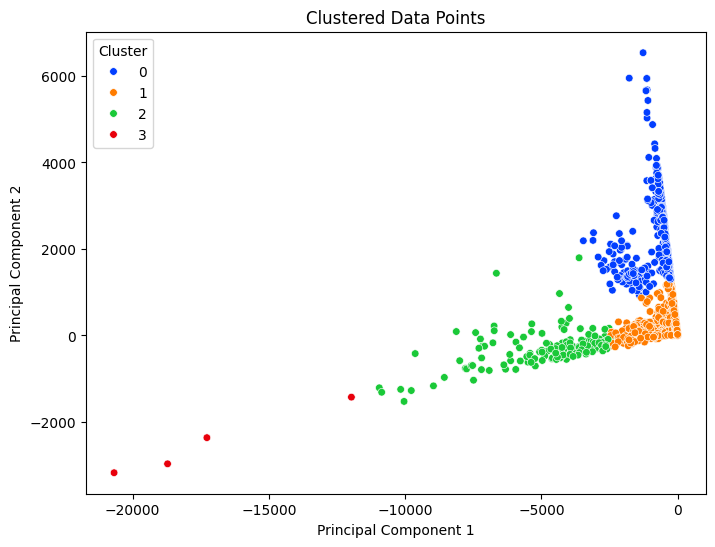

In [5]:
# Visualize Results
import numpy as np
from pyspark.ml.feature import PCA

# Reduce to 2 principal components
pca = PCA(k=2, inputCol="features", outputCol="pca_features")
pca_model = pca.fit(transformed)
pca_result = pca_model.transform(transformed)
# Collect data to Pandas for plotting
plot_data = pca_result.select("pca_features", "prediction").collect()

# Prepare data for matplotlib
import numpy as np
import pandas as pd

pca_points = np.array([row['pca_features'] for row in plot_data])
labels = [row['prediction'] for row in plot_data]

df_plot = pd.DataFrame({
    'PC1': pca_points[:, 0],
    'PC2': pca_points[:, 1],
    'Cluster': labels
})
 
### **4. Plot Using Matplotlib or Seaborn**
import matplotlib.pyplot as plt
import seaborn as sns

# Plot clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x="PC1", y="PC2", hue="Cluster", palette="bright", data=df_plot, s=30)

plt.title("Clustered Data Points")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title='Cluster')
plt.show()